## creating new variables and transformations based on EDA outcome and based on literature reviews


In [60]:
library(dplyr)
library(ggplot2)
library(DBI)
library(tidyverse)  


Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.1.0     v purrr   0.3.4
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'readr' was built under R version 4.0.5"
Warning message:
"package 'forcats' was built under R version 4.0.5"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [1]:
data <- read.csv('C:/Users/galie/DataScience/project/final_data_dengue.csv') 
head (data)

,cum_week1,wk_atm_p,wk_dew_p,wk_avg_max_tmp,wk_max_tm,wk_avg_tm,wk_min_tm,wk_avg_min_tmp,wk_avg_hum,wk_min_hum,avg_max_blast_w,max_blast_w,avg_wind_speed,wk_avg_precipitation,num_patients,male_perc,year,month,log_num_patients
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1,943.7298,18.03250,30.78000,35.7,24.19155,15.8,19.00000,71.23571,25,8.674286,13.3,1.775595,3.222857,64,48,2013,1,4.174387
2,2,941.4388,18.37952,28.67143,36.7,22.99917,15.8,19.44286,77.61310,29,10.002857,19.3,1.926786,9.600000,112,38,2013,1,4.727388
3,3,940.8427,19.05929,28.75714,33.5,22.61821,16.8,19.40000,81.73571,41,9.631429,21.3,1.798095,6.800000,137,51,2013,2,4.927254
4,4,941.9092,18.53536,27.72571,33.7,22.11857,15.8,18.64286,81.43690,45,9.225714,15.4,1.783333,6.314286,254,43,2013,2,5.541264
5,5,943.2068,19.78702,26.15143,32.8,21.84917,16.3,19.73714,88.72024,49,7.625714,14.7,1.404048,12.982857,375,42,2013,2,5.929589
6,6,942.4817,18.84524,28.51714,35.5,22.67262,16.6,18.94857,80.74881,35,8.388571,13.2,1.613333,9.354286,641,42,2013,2,6.464588


In [4]:
#make the plots smaller..
options(repr.plot.width=6, repr.plot.height=6)

#### The log_num_patients was already created previously

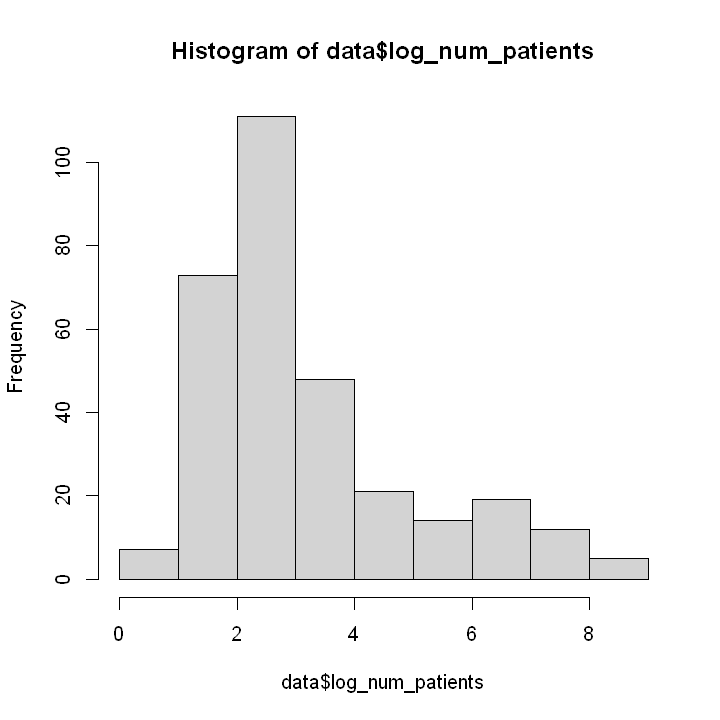

In [22]:
hist (data$log_num_patients)

In [144]:
# As mentioned in the EDA, I found that above 4 is like a seperate group, that has a bit different characterists
# Therefore:
data$alot_of_patients_yn <- factor(ifelse(data$log_num_patients > 4 ,1,0),
                                      levels=c(1,0))

In [24]:
summary (data$alot_of_patients_yn)
# thats an 'ok' split, so I will keep this one

alot of patients    not that many 
              71              239

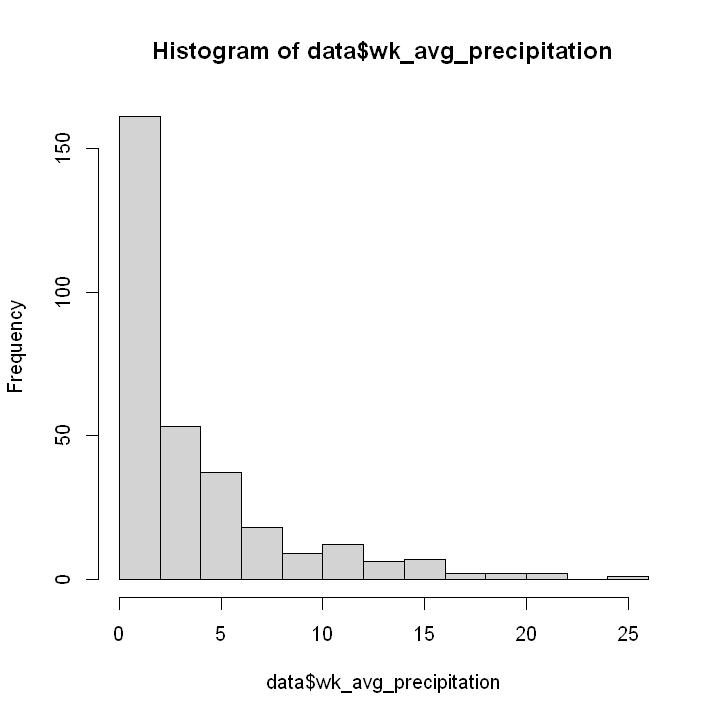

In [5]:
# This parameter was also found to have different distribution
hist (data$wk_avg_precipitation)

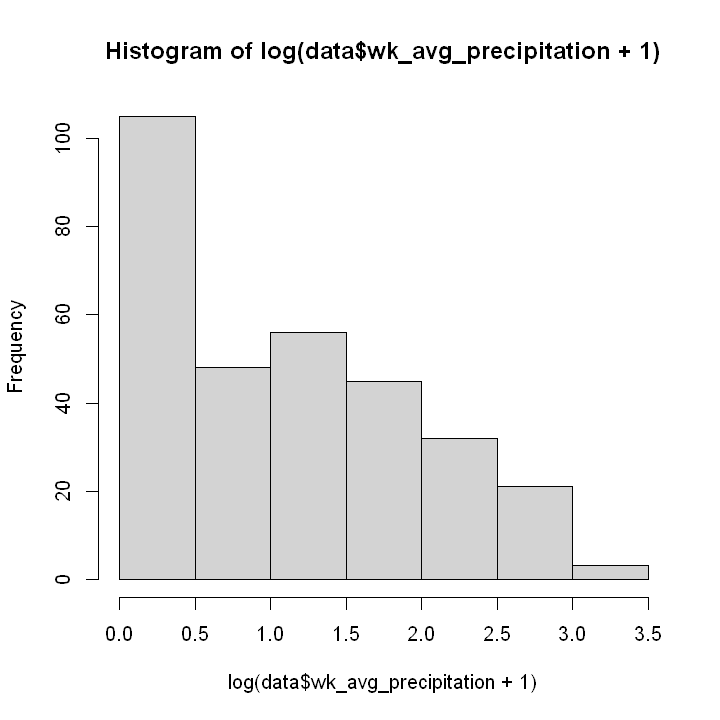

In [7]:
hist(log(data$wk_avg_precipitation+1))
# maybe should consider creating a 'dry week' parameter, where the percipitation is less than 0.5?

In [8]:
data$log_wk_avg_precipitation <- log(data$wk_avg_precipitation+1)

In [141]:
data$dry_week_yn <- factor(ifelse(data$log_wk_avg_precipitation < 0.5 ,1,0),
                                      levels=c(1,0))

In [11]:
summary (data$dry_week_yn)
# thats a 'good' split

dry week not dry week 
         105          205

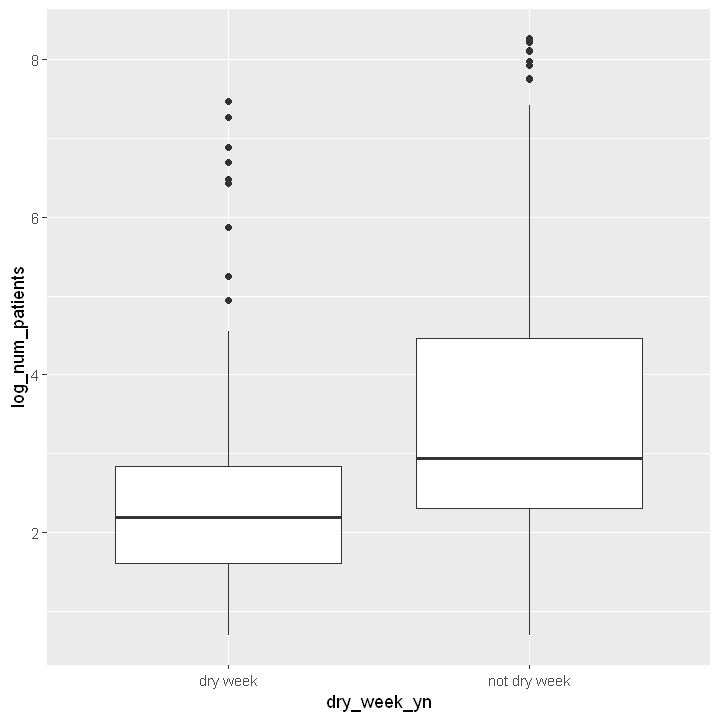

In [18]:
# see distribution with the outcome
ggplot(data, aes(x=dry_week_yn, y=log_num_patients)) + 
  geom_boxplot()


In [21]:
t.test(data$log_num_patients ~ data$dry_week_yn,var.equal = F,paired = F)
# it's very significant


	Welch Two Sample t-test

data:  data$log_num_patients by data$dry_week_yn
t = -5.4484, df = 262.22, p-value = 1.171e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.413737 -0.663147
sample estimates:
    mean in group dry week mean in group not dry week 
                  2.524151                   3.562593 


In [28]:
# check the groups
table(data$dry_week_yn, data$alot_of_patients_yn)
chisq.test(table(data$dry_week_yn, data$alot_of_patients_yn))

              
               alot of patients not that many
  dry week                   11            94
  not dry week               60           145


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data$dry_week_yn, data$alot_of_patients_yn)
X-squared = 12.843, df = 1, p-value = 0.0003388


### There aren't that many variables in this data to 'play with', and no other clear groups were found.
### Thus, I looked in the literature for additional options.

These are based of the 'Bioclimatic Predictors for Supporting Ecological Applications in the Conterminous United States'

These variables are created using the existing ones, no missing values are expected. 

In [29]:
# create season/ quarter 
data$season <- factor(ifelse(data$month== 9 |data$month== 10 |data$month== 11 ,1,
                            ifelse(data$month== 12 |data$month== 1 |data$month== 2,2,
                            ifelse(data$month== 3 |data$month== 4 |data$month== 5,3,4))),
                                      levels=c(1,2,3,4),labels=c("Spring","Summer","Autumn","Winter"))

# this was based on information from a brazilian website

In [30]:
# annual mean temperature BIO01
ann_mean <- data %>%  group_by(year) %>% summarise_at(vars(wk_avg_tm),           
               list(name = mean))

In [131]:
data <- data %>%
  rename(ann_mean_tmp = name)

In [31]:
#left join into the data
data <-merge(x=data,y=ann_mean,by="year",all.x=TRUE)

In [32]:
#calculate diurnal range (max temp-minimum temp) 
data$diurnal_range <- data$wk_avg_max_tm - data$wk_avg_min_tm

In [33]:
# Mean diurnal range - BIO02
diurnal_range<- data %>%  group_by(month,year) %>% summarise(mean_diu_range = mean(diurnal_range))

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



In [34]:
#left join into the data
data <-merge(x=data,y=diurnal_range,by=c("month","year"),all.x=TRUE)

In [41]:
# Isothermality (Mean diurnal range/Temperature annual range) (* 100) BIO03
data$Isothermality <- data$mean_diu_range/data$annual_range*100

In [35]:
#max temp of warmest month BIO05
max_temp <- data %>%  group_by(month,year) %>% summarise(max_y_temp = max(wk_avg_max_tmp))

# min temp of coldest month BIO06

min_temp <- data %>%  group_by(month,year) %>% summarise(min_y_temp = min(wk_avg_min_tmp))


`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



In [36]:
# Combine both 
data<-data %>% left_join(max_temp)

Joining, by = c("month", "year")



In [37]:
data<- data %>% left_join(min_temp)

Joining, by = c("month", "year")



In [39]:
# Temperature annual range BIO07
data$annual_range <- data$max_y_temp-data$min_y_temp

In [43]:
# monthly average temperature
m_avg_tm<- data %>%  group_by(month,year) %>% summarise(mean_temp = mean(wk_avg_tm))

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



In [44]:
data<- data %>% left_join(m_avg_tm)

Joining, by = c("month", "year")



In [49]:
# monthly precipitation 
monthly_precipitation<- data %>%  group_by(month,year) %>% summarise(monthly_precipitation = sum(wk_avg_precipitation))
data<- data %>% left_join(monthly_precipitation)

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.

Joining, by = c("month", "year")



In [109]:
#precipitation of wettest month BIO13

wettest_m <- data %>%  group_by(year) %>% summarise(max_y_precipitation = max(monthly_precipitation))
data<- data %>% left_join(wettest_m)

Joining, by = "year"



In [51]:
#precipitation of driest month BIO14
driest_m <- data %>%  group_by(year) %>% summarise(min_y_precipitation = min(monthly_precipitation))
data<- data %>% left_join(driest_m)

Joining, by = "year"



In [67]:
# quarterly precipitation 
q_precipitation <- data %>%  group_by(season,year) %>% summarise(q_precipitation = sum(wk_avg_precipitation))
data<- data %>% left_join(q_precipitation)

`summarise()` has grouped output by 'season'. You can override using the `.groups` argument.

Joining, by = c("year", "season")



In [58]:
q_precipitation

season,year,q_precipitation
<fct>,<int>,<dbl>
Spring,2013,29.659048
Spring,2014,14.735714
Spring,2015,36.811429
Spring,2016,31.364381
Spring,2017,15.328571
Spring,2018,43.182857
Summer,2013,84.497143
Summer,2014,82.824524
Summer,2015,70.565714


In [69]:
# precipitation of driest quarter BIO17
driest_q <- data %>%  group_by(year) %>% summarise(min_y_q_precipitation = min(q_precipitation))


In [70]:
data<- data %>% left_join(driest_q)

Joining, by = "year"



In [71]:
# precipitation of  wettest quarter BIO16
wettest_q <- data %>%  group_by(year) %>% summarise(max_y_q_precipitation = max(q_precipitation))
data<- data %>% left_join(wettest_q)

Joining, by = "year"



In [72]:
# quarterly temp
Q_temp <- data %>%  group_by(season,year) %>% summarise(q_temp = mean(wk_avg_tm))
data<- data %>% left_join(Q_temp)

`summarise()` has grouped output by 'season'. You can override using the `.groups` argument.

Joining, by = c("year", "season")



In [107]:
# Mean Temperature of warmest quarter BIO10

hottest_q <- data %>%  group_by(year) %>% summarise(max_y_q_temp = max(q_temp))
data<- data %>% left_join(hottest_q)

Joining, by = "year"



In [108]:
# Mean Temperature of coldest quarter BIO11

coldest_q <- data %>%  group_by(year) %>% summarise(min_y_q_temp = min(q_temp))
data<- data %>% left_join(coldest_q)

Joining, by = "year"



In [74]:
#summarize quarters' temperatures and precipitation 
temp_q <- data %>%  group_by(year) %>% summarise(max_y_q_temp = max(q_temp),
                                                       min_y_q_temp = min(q_temp),
                                                       max_y_q_precipitation = max(q_precipitation),
                                                       min_y_q_precipitation = min(q_precipitation),
                                                    
                                                      )
temp_q

year,max_y_q_temp,min_y_q_temp,max_y_q_precipitation,min_y_q_precipitation
<int>,<dbl>,<dbl>,<dbl>,<dbl>
2013,22.56830,17.93779,84.49714,17.985524
2014,22.95152,17.97791,82.82452,9.015714
2015,23.70061,18.53152,70.56571,24.634286
2016,23.16082,17.92730,113.19143,8.331429
2017,22.97852,18.17738,88.08333,9.069048
2018,23.47264,18.63865,81.94810,15.068571


In [75]:
# Mean temperature of wettest quarter BIO08
final_data %>% group_by(season, year) %>%  summarise (mean_t = mean (mean_temp),
                                                     max_y_q_precipitation = max(q_precipitation),
                                                     min_y_q_precipitation = min(q_precipitation))  %>% 
arrange (desc(max_y_q_precipitation,year)) 

`summarise()` has grouped output by 'season'. You can override using the `.groups` argument.



season,year,mean_t,max_y_q_precipitation,min_y_q_precipitation
<fct>,<int>,<dbl>,<dbl>,<dbl>
Summer,2016,23.16082,113.191429,113.191429
Summer,2017,22.97852,88.083333,88.083333
Summer,2013,22.56830,84.497143,84.497143
Summer,2014,22.95152,82.824524,82.824524
Summer,2018,23.47264,81.948095,81.948095
Autumn,2013,21.43708,74.852381,74.852381
Summer,2015,23.70061,70.565714,70.565714
Autumn,2018,22.52113,62.654762,62.654762
Autumn,2015,21.70013,50.406190,50.406190


In [76]:
# Mean temperature of wettest quarter
w1 <- data.frame(season=c(2,2,2,2,2,2),
                year=c(2016,2017,2013,2014,2018,2015),
                mean_t = c(23.16082,22.97852,22.56830,22.95152,23.47264,23.70061))
w1$season <- factor(w1$season)
w1

season,year,mean_t
<fct>,<dbl>,<dbl>
2,2016,23.16082
2,2017,22.97852
2,2013,22.56830
2,2014,22.95152
2,2018,23.47264
2,2015,23.70061


In [77]:
# insert the new variable into the data 

data <-merge(x=data,y=w1,by="year",all.x=TRUE)

In [78]:
 # Mean Temperature of Driest Quarter BIO09
w2 <- data.frame(season=c(4,4,4,4,4,4),
                year=c(2016,2014,2017,2018,2013,2015),
                mean_t_d = c(17.92730,17.97791,18.17738,18.63865,17.93779,18.53152))
w2$season <- factor(w2$season)
w2

season,year,mean_t_d
<fct>,<dbl>,<dbl>
4,2016,17.92730
4,2014,17.97791
4,2017,18.17738
4,2018,18.63865
4,2013,17.93779
4,2015,18.53152


In [79]:
# insert the new variable into the data 
final_data <-merge(x=data,y=w2,by="year",all.x=TRUE)

In [101]:
# clear the mess I've done with the duplicate values..
library(DataExplorer)
data <- drop_columns(data, c("season.y"))

In [112]:
data <- drop_columns(data, c("percipitation.x"))

In [116]:
data <- data %>%
  rename(percipitation = percipitation.y)

In [89]:
data <- data %>%
  rename(season = season.x)

In [103]:
#data <- data[, -40] 

In [91]:
# Precipitation of Coldest Quarter BIO17

data %>% group_by(season,year) %>%  summarise (percipitation = sum (monthly_precipitation),
                                                     max_y_q_temp = max(q_temp),
                                                     min_y_q_temp = min(q_temp))  %>% 
arrange (min_y_q_temp,year) # for the max i arranged it desc with max

`summarise()` has grouped output by 'season'. You can override using the `.groups` argument.



season,year,percipitation,max_y_q_temp,min_y_q_temp
<fct>,<int>,<dbl>,<dbl>,<dbl>
Winter,2016,33.67429,17.92730,17.92730
Winter,2013,84.11238,17.93779,17.93779
Winter,2014,38.99429,17.97791,17.97791
Winter,2017,36.27619,18.17738,18.17738
Winter,2015,117.98857,18.53152,18.53152
Winter,2018,62.59429,18.63865,18.63865
Spring,2013,124.31810,19.37982,19.37982
Spring,2014,61.15286,20.38999,20.38999
Spring,2018,186.09714,20.59101,20.59101


In [92]:
w3 <- data.frame(season=c(4,4,4,4,4,4),
                year=c(2016,2013,2014,2017,2015,2018),
                percipitation = c(33.67429,84.11238,38.99429,36.27619,117.98857,62.59429))
w3$season <- factor(w3$season)
w3

season,year,percipitation
<fct>,<dbl>,<dbl>
4,2016,33.67429
4,2013,84.11238
4,2014,38.99429
4,2017,36.27619
4,2015,117.98857
4,2018,62.59429


In [93]:
# Precipitation of warmest Quarter BIO18

w4 <- data.frame(season=c(2,2,2,2,2,2),
                year=c(2015,2018,2016,2017,2014,2013),
                percipitation_1 = c(246.10571,327.79238,482.09429,398.75381,331.29810,312.34286))
w4$season <- factor(w4$season)
w4

season,year,percipitation_1
<fct>,<dbl>,<dbl>
2,2015,246.1057
2,2018,327.7924
2,2016,482.0943
2,2017,398.7538
2,2014,331.2981
2,2013,312.3429


In [95]:
# insert the new variable into the data 
data <-merge(x=data,y=w3,by="year",all.x=TRUE)

Warning message in merge.data.frame(x = data, y = w3, by = "year", all.x = TRUE):
"column names 'season.x', 'season.y' are duplicated in the result"


In [96]:
# insert the new variable into the data 
final_data <-merge(x=data,y=w4,by="year",all.x=TRUE)

Warning message in merge.data.frame(x = data, y = w4, by = "year", all.x = TRUE):
"column names 'season.x', 'season.y', 'season.x', 'season.y' are duplicated in the result"


In [45]:
#annual precipitation BIO12
ann_precipitation <- data %>%  group_by(year) %>% summarise(ann_precipitation = sum(wk_avg_precipitation))
ann_precipitation

year,ann_precipitation
<int>,<dbl>
2013,206.9941
2014,148.0960
2015,182.4176
2016,192.3689
2017,144.6954
2018,202.8543


In [47]:
data<- data %>% left_join(ann_precipitation)

Joining, by = "year"



### Now for the seasonality parameters

In [119]:
temp.ts <- ts(final_data$wk_avg_tm, frequency = 12)

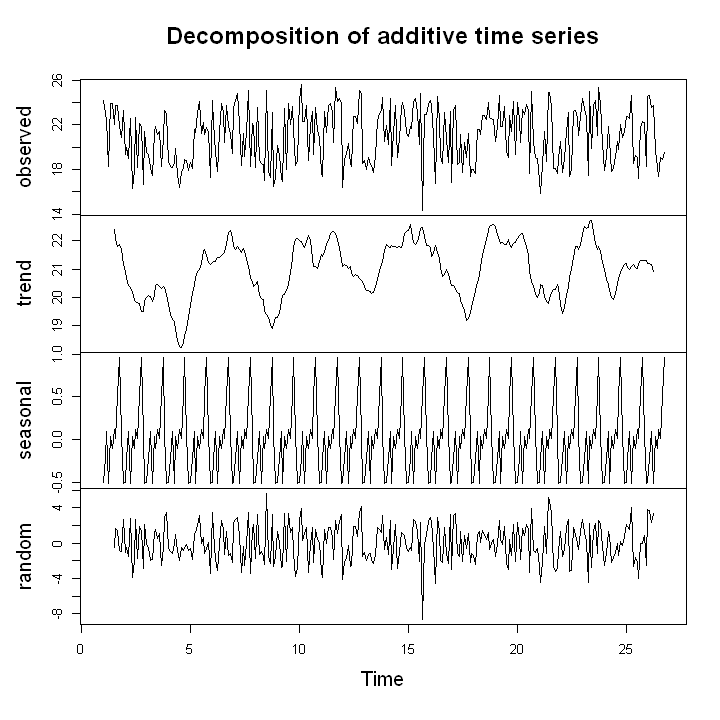

In [120]:
plot(decompose(temp.ts))

In [121]:
temp.dec <- decompose(temp.ts)

In [122]:
temp.dec$seasonal

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
2,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
3,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
4,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
5,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
6,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
7,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
8,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
9,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750
10,-0.49459169,-0.21632337,0.09530241,-0.50451651,0.04294758,-0.10437281,0.11792376,0.02088069,0.52287297,0.96366717,0.06193732,-0.50572750


In [123]:
# Temperature Seasonality (CV) BIO04
x<- data.frame(seasonality= c(0.164890763,-0.116858324,-0.017273947,-0.606672983,0.021871199,0.051850374,-0.006277196,0.149770657,0.386283648,-0.073142891,-0.089660641,0.135219341)
               ,month=c(1,2,3,4,5,6,7,8,9,10,11,12))
data<- data %>% left_join(x) 


Joining, by = "month"



In [124]:
#Precipitation Seasonality
per.ts <- ts(final_data$monthly_precipitation, frequency = 12)

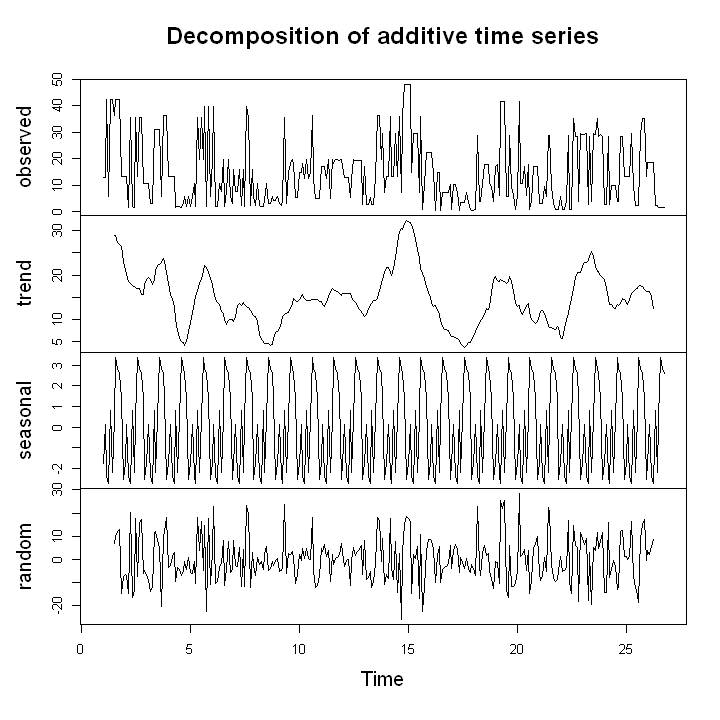

In [125]:
plot(decompose(per.ts))

In [126]:
per.dec <- decompose(per.ts)

In [127]:
per.dec$seasonal

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
2,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
3,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
4,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
5,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
6,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
7,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
8,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
9,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832
10,-1.7535956,0.1164635,-2.3391689,-2.7401080,0.8167875,-2.2240494,0.4212981,3.3954809,2.8555038,2.6080517,1.3774197,-2.5340832


In [128]:
y<- data.frame(per_seasonality=c(-0.2488066,2.4634417,2.4782576,2.1660677,0.2064082,0.3750689,-1.5570735,-0.6862640,-1.1052278,-2.1214202,-0.9112564,-1.0591955),
month=c(1,2,3,4,5,6,7,8,9,10,11,12))
data<- data %>% left_join(y) 

Joining, by = "month"



In [133]:
head(data)

,year,month,cum_week1,wk_atm_p,wk_dew_p,wk_avg_max_tmp,wk_max_tm,wk_avg_tm,wk_min_tm,wk_avg_min_tmp,...,max_y_q_precipitation,q_temp,mean_t,mean_t_d,percipitation,max_y_q_temp,min_y_q_temp,max_y_precipitation,seasonality,per_seasonality
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,1,1,943.7298,18.03250,30.78000,35.7,24.19155,15.8,19.00000,...,84.49714,22.56830,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,0.16489076,-0.2488066
2,2013,1,2,941.4388,18.37952,28.67143,36.7,22.99917,15.8,19.44286,...,84.49714,22.56830,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,0.16489076,-0.2488066
3,2013,3,9,943.1124,18.79512,27.91429,36.2,22.44643,16.7,19.18857,...,84.49714,21.43708,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,-0.01727395,2.4782576
4,2013,9,34,948.7310,13.33714,24.80286,32.0,18.25333,9.2,13.66571,...,84.49714,19.37982,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,0.38628365,-1.1052278
5,2013,3,7,942.2117,18.41726,30.44286,35.6,23.95131,15.5,18.72000,...,84.49714,21.43708,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,-0.01727395,2.4782576
6,2013,3,8,942.8707,17.91762,30.70286,35.3,23.93357,15.1,18.53429,...,84.49714,21.43708,22.5683,17.93779,84.11238,22.5683,17.93779,42.20571,-0.01727395,2.4782576


In [145]:
summary (data)

      year          month          cum_week1         wk_atm_p    
 Min.   :2013   Min.   : 1.000   Min.   :  1.00   Min.   :931.2  
 1st Qu.:2014   1st Qu.: 4.000   1st Qu.: 78.25   1st Qu.:942.6  
 Median :2016   Median : 6.500   Median :155.50   Median :944.5  
 Mean   :2016   Mean   : 6.484   Mean   :155.50   Mean   :945.0  
 3rd Qu.:2017   3rd Qu.: 9.000   3rd Qu.:232.75   3rd Qu.:947.7  
 Max.   :2018   Max.   :12.000   Max.   :310.00   Max.   :955.8  
    wk_dew_p      wk_avg_max_tmp    wk_max_tm       wk_avg_tm    
 Min.   : 9.826   Min.   :21.14   Min.   :26.30   Min.   :14.31  
 1st Qu.:14.206   1st Qu.:25.15   1st Qu.:31.90   1st Qu.:18.73  
 Median :16.537   Median :27.29   Median :33.75   Median :21.32  
 Mean   :16.230   Mean   :27.41   Mean   :33.70   Mean   :21.00  
 3rd Qu.:18.345   3rd Qu.:29.54   3rd Qu.:35.80   3rd Qu.:23.17  
 Max.   :20.966   Max.   :34.28   Max.   :40.70   Max.   :25.65  
   wk_min_tm     wk_avg_min_tmp     wk_avg_hum      wk_min_hum   
 Min.   : 

In [138]:
# I will change the dry_week_yn into int for later
data$dry_week_yn <- as.integer(data$dry_week_yn)


In [140]:
data$season.x <- as.integer(data$season.x)


### Now we can move to the feature selection part. 

In [146]:
# writing csv to move to the next notebook.
write.csv(data, "final_data_inc_newstuff.csv", row.names = F)